## Residual network

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add,GlobalAveragePooling2D
from tensorflow.keras.models import  Sequential, Model, load_model

import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import callbacks

import os
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline
import seaborn as sns
import keras
# If you would like to make further imports from Tensorflow, add them here

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam




#### The Fashion-MNIST dataset

In this assignment, you will use the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). It consists of a training set of 60,000 images of fashion items with corresponding labels, and a test set of 10,000 images. 

#### Load the dataset

In [2]:
# Load and preprocess the Fashion-MNIST dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_images = train_images[:5000] / 255.
train_labels = train_labels[:5000]

test_images = test_images / 255.

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

In [3]:
# Create Dataset objects for the training and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [4]:
# Get dataset labels

image_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Create custom layers for the residual blocks

In [5]:


class ResidualBlock(Layer):

    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
    def build(self, input_shape):
        """
        This method should build the layers according to the above specification. Make sure 
        to use the input_shape argument to get the correct number of filters, and to set the
        input_shape of the first layer in the block.
        """
        self.bn1 = BatchNormalization(input_shape=input_shape)
        self.conv1 = Conv2D(input_shape[-1], kernel_size=(3,3), padding='SAME')
        self.bn2 = BatchNormalization()
        self.conv2 = Conv2D(input_shape[-1], kernel_size=(3,3), padding='SAME')
        
    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the build method.
        """
        
        x = self.bn1(inputs, training=True)
        x = tf.nn.relu(x)
        x = self.conv1(x)
        x = self.bn2(x, training=True)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        
        return (x + inputs)

In [6]:
# Test your custom layer - the following should create a model using your layer

test_model = tf.keras.Sequential([ResidualBlock(input_shape=(28, 28, 1), name="residual_block")])
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block (ResidualBloc (None, 28, 28, 1)         28        
Total params: 28
Trainable params: 24
Non-trainable params: 4
_________________________________________________________________


In [7]:


class FiltersChangeResidualBlock(Layer):

    def __init__(self, out_filters, **kwargs):
        """
        The class initialiser should call the base class initialiser
        """
        super(FiltersChangeResidualBlock, self).__init__(**kwargs)
        self.out_filters = out_filters
        
    def build(self, input_shape):
        """
        This method should build the layers using the input_shape argument to get the correct number of filters
        """
        self.bn1 = BatchNormalization(input_shape=input_shape)
        self.conv1 = Conv2D(input_shape[-1], kernel_size=(3,3), padding='SAME')
        self.bn2 = BatchNormalization()
        self.conv2 = Conv2D(self.out_filters, kernel_size=(3,3), padding='SAME')
        self.conv3 = Conv2D(self.out_filters, kernel_size=(1,1))
        
    def call(self, inputs, training=False):
       
        
        x = self.bn1(inputs, training=True)
        x = tf.nn.relu(x)
        x = self.conv1(x)
        x = self.bn2(x, training=True)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        
        return x+ self.conv3(inputs)

In [8]:
# Test your custom layer 

test_model = tf.keras.Sequential([FiltersChangeResidualBlock(16, input_shape=(32, 32, 3), name="fc_resnet_block")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_resnet_block (FiltersChan (None, 32, 32, 16)        620       
Total params: 620
Trainable params: 608
Non-trainable params: 12
_________________________________________________________________


In [9]:
####Create a custom model that integrates the residual blocks ####
class ResNetModel(Model):

    def __init__(self, **kwargs):
       
        super(ResNetModel, self).__init__(**kwargs)
        self.conv1 = Conv2D(32, kernel_size=(7,7), strides=2)
        self.residual1 = ResidualBlock()
        self.conv2 = Conv2D(32, kernel_size=(3,3), strides=2)
        self.residual2 = FiltersChangeResidualBlock(64)
        self.flatten = Flatten()
        self.fc = Dense(10, activation='softmax')
        
    def call(self, inputs, training=False):
        
        
        x = self.conv1(inputs)
        x = self.residual1(x, training=True)
        x = self.conv2(x)
        x = self.residual2(x, training=True)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x

In [10]:
# Create the model

resnet_model = ResNetModel()

#### Define the optimizer and loss function

In [11]:
# Create the optimizer and loss
optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

In [12]:
#Define the grad functio
@tf.function
def grad(model, inputs, targets, loss):
    with tf.GradientTape() as tape:
        loss_value = loss(targets, model(inputs))
        gradients = tape.gradient(loss_value, model.trainable_variables)
        
    return (loss_value, gradients)

##### Define the custom training loop

In [13]:
def train_resnet(model, num_epochs, dataset, optimizer, loss, grad_fn):
    """
    custom training loop
    """
    train_loss_results = []
    train_accuracy_results = []
    
    for epoch in range(num_epochs):
        
        epoch_loss = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
        for x,y in dataset:
            
            loss_value, gradients = grad_fn(model, x, y, loss)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            epoch_loss(loss_value)
            epoch_accuracy(y, model(x))
        
        train_loss_results.append(epoch_loss.result())
        train_accuracy_results.append(epoch_accuracy.result())
        
        print(f"Epoch: {epoch+1} Loss: {epoch_loss.result():.2f} Accuracy: {epoch_accuracy.result():.2f}")    
    return train_loss_results, train_accuracy_results
    

In [14]:
# Train the model for 8 epochs
train_loss_results, train_accuracy_results = train_resnet(resnet_model, 8, train_dataset, optimizer_obj, 
                                                          loss_obj, grad)

Epoch: 1 Loss: 0.72 Accuracy: 0.79
Epoch: 2 Loss: 0.45 Accuracy: 0.87
Epoch: 3 Loss: 0.35 Accuracy: 0.91
Epoch: 4 Loss: 0.27 Accuracy: 0.94
Epoch: 5 Loss: 0.22 Accuracy: 0.96
Epoch: 6 Loss: 0.21 Accuracy: 0.96
Epoch: 7 Loss: 0.19 Accuracy: 0.97
Epoch: 8 Loss: 0.16 Accuracy: 0.98


#### Plot the learning curves

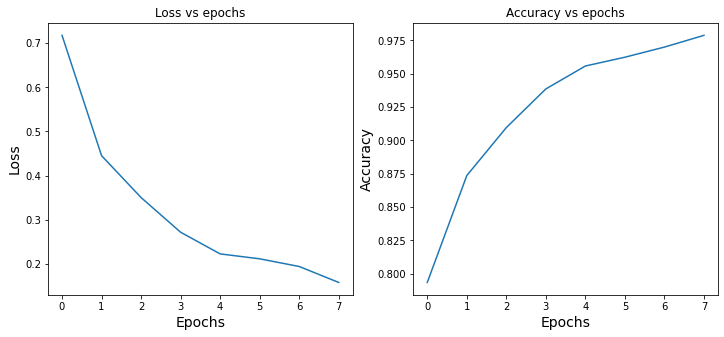

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Evaluate the model performance on the test dataset

In [16]:
# Compute the test loss and accuracy
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    model_output = resnet_model(x)
    epoch_loss_avg(loss_obj(y, model_output))  
    epoch_accuracy(to_categorical(y), model_output)

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 0.768
Test accuracy: 81.780%


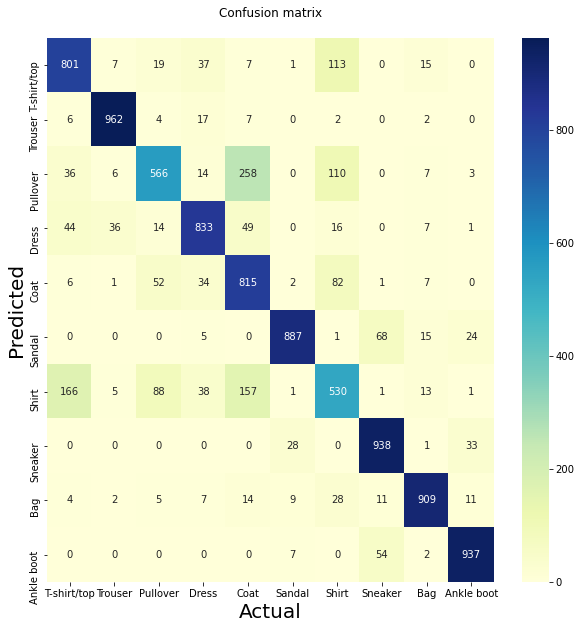

In [17]:
#Confution Matrix and Classification Report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

plt.figure(figsize=(10, 8))


true_categories = tf.concat([y for x, y in test_dataset], axis=0)

Y_pred = resnet_model.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(true_categories, y_pred)


df_cm = pd.DataFrame(cm, index=image_labels, columns=image_labels)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted",fontsize = 20)
plt.xlabel("Actual",fontsize = 20)
plt.show()



#  Using pretrained Rsenet

In [18]:
# Load and preprocess the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

test_labels_ = test_labels


#train_images = train_images[..., np.newaxis]
#test_images = test_images[..., np.newaxis]
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [19]:
train_images = train_images.reshape(train_images.shape[0],-1)
test_images = test_images.reshape(test_images.shape[0],-1)

train_images.shape, test_images.shape

((60000, 784), (10000, 784))

In [20]:
#Convert the images into 3 channels
train_images=np.dstack([train_images] * 3)
test_images=np.dstack([test_images]*3)
train_images.shape,test_images.shape

((60000, 784, 3), (10000, 784, 3))

In [21]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
train_images = train_images.reshape(-1, 28,28,3)
test_images= test_images.reshape (-1,28,28,3)
train_images.shape,test_images.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [22]:
'''
from keras.preprocessing.image import img_to_array, array_to_img
train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((96,96))) for im in train_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((96,96))) for im in test_images])
train_images.shape,test_images.shape
'''

'\nfrom keras.preprocessing.image import img_to_array, array_to_img\ntrain_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((96,96))) for im in train_images])\ntest_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((96,96))) for im in test_images])\ntrain_images.shape,test_images.shape\n'

In [23]:
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

In [24]:
# simple method to use pretrained model
'''
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D

resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()

model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
'''

"\nfrom tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D\n\nresnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\n\nfor layer in resnet_model.layers:\n    if isinstance(layer, BatchNormalization):\n        layer.trainable = True\n    else:\n        layer.trainable = False\n\nmodel = Sequential()\n\nmodel.add(resnet_model)\nmodel.add(GlobalAveragePooling2D())\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dropout(.25))\nmodel.add(BatchNormalization())\nmodel.add(Dense(10, activation='softmax'))\n\n\nmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])\n"

In [49]:
# Call the function loading the pretrained model and display its summary
base_model = tf.keras.applications.ResNet50(include_top=True, weights="imagenet",input_tensor=None, input_shape=None,
                                            pooling=None,
                                            classes=1000)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

ResNet50 neural-net has batch-normalization (BN) layers and using the pre-trained model causes issues with BN layers, if the target dataset on which model is being trained on is different from the originally used training dataset. This is because the BN layer would be using statistics of training data, instead of one used for inference.

In [56]:

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

        
def remove_head(pretrained_model):
    """
    This function should create and return a new model, using the input and output 
    tensors 
    """
    
    inputs = pretrained_model.input
    outputs = pretrained_model.get_layer('conv5_block3_out').output
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model     

feature_extractor = remove_head(base_model)
feature_extractor.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [71]:
new_model = Sequential([
    feature_extractor,
    BatchNormalization(),
    Conv2D(500, 3, activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(200, 3, activation='relu', padding="same"),
    
 
    BatchNormalization(),
    Dense(100, activation='relu'),
    Dropout(.2),
    Dense(10, activation='softmax')
])
    
new_model.summary()

opt = Adam(learning_rate=0.001)
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_52 (Batc (None, 7, 7, 2048)        8192      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 7, 7, 512)         9437696   
_________________________________________________________________
batch_normalization_53 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
batch_normalization_54 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 1, 512)       

In [112]:
new_model = Sequential([
    feature_extractor,
    BatchNormalization(),
    Conv2D(512, 3, activation='relu', padding="same"),
    BatchNormalization(),    
    
    Conv2D(512, (7,7), activation='relu',padding="same"),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),    
    Dense(10, activation='softmax'),
   
])
    
new_model.summary()
#GlobalAveragePooling2D(),

opt = Adam(learning_rate=0.001)
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_167 (Bat (None, 7, 7, 2048)        8192      
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 7, 7, 512)         9437696   
_________________________________________________________________
batch_normalization_168 (Bat (None, 7, 7, 512)         2048      
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 7, 7, 512)         12845568  
_________________________________________________________________
batch_normalization_169 (Bat (None, 7, 7, 512)         2048      
_________________________________________________________________
global_average_pooling2d_9 ( (None, 512)             

In [87]:

# Incorporating reduced learning and early stopping for callback
reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [ eary_stopping]

In [113]:
bs = 64                         
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                  featurewise_std_normalization=True,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
 
# Fit the train_datagen to calculate the train data statistics
train_datagen.fit(train_images)
 
# Create a separate ImageDataGenerator instance
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                        featurewise_std_normalization=True)
 
# Fit the validation_datagen on the train data 
validation_datagen.fit(train_images)
 
# Use any of the flow methods. Here I have used flow()
training_generator = train_datagen.flow(train_images, train_labels, batch_size= bs, seed=7)
validation_generator = validation_datagen.flow(test_images, test_labels, batch_size= bs, seed=7)
 
history = new_model.fit(training_generator, epochs= 50, 
                                         validation_data=validation_generator, callbacks=callbacks)

Epoch 1/50
938/938 [==============================] - 84s 86ms/step - loss: 1.1388 - accuracy: 0.6125 - val_loss: 0.8744 - val_accuracy: 0.6975
Epoch 2/50
938/938 [==============================] - 80s 85ms/step - loss: 0.7403 - accuracy: 0.7302 - val_loss: 0.6518 - val_accuracy: 0.7552
Epoch 3/50
938/938 [==============================] - 83s 88ms/step - loss: 0.6772 - accuracy: 0.7505 - val_loss: 0.5773 - val_accuracy: 0.7867
Epoch 4/50
938/938 [==============================] - 83s 88ms/step - loss: 0.6124 - accuracy: 0.7758 - val_loss: 0.5561 - val_accuracy: 0.7951
Epoch 5/50
938/938 [==============================] - 84s 89ms/step - loss: 0.5683 - accuracy: 0.7917 - val_loss: 0.5269 - val_accuracy: 0.7992
Epoch 6/50
938/938 [==============================] - 87s 92ms/step - loss: 0.5436 - accuracy: 0.7973 - val_loss: 0.4830 - val_accuracy: 0.8224
Epoch 7/50
938/938 [==============================] - 92s 98ms/step - loss: 0.5246 - accuracy: 0.8051 - val_loss: 0.4914 - val_accuracy:

C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



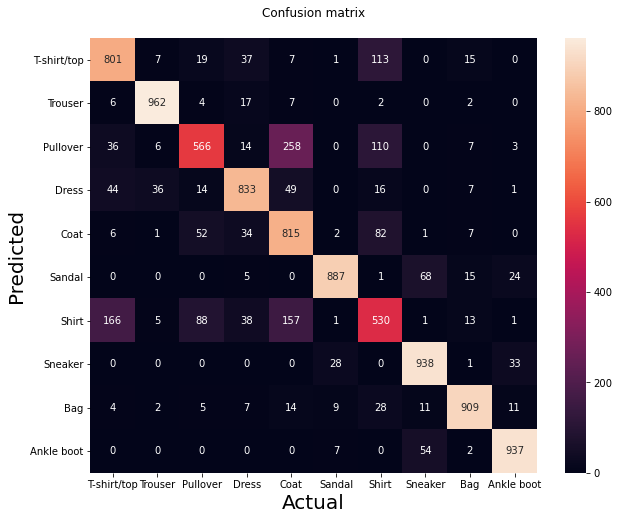

In [152]:
plt.figure(figsize=(10, 8))

Y_pred = new_model.predict_classes(validation_generator)

cm = confusion_matrix(test_labels_, y_pred)

df_cm = pd.DataFrame(cm, index=image_labels, columns=image_labels)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="rocket")
plt.ylabel("Predicted",fontsize = 20)
plt.xlabel("Actual",fontsize = 20)
plt.show()


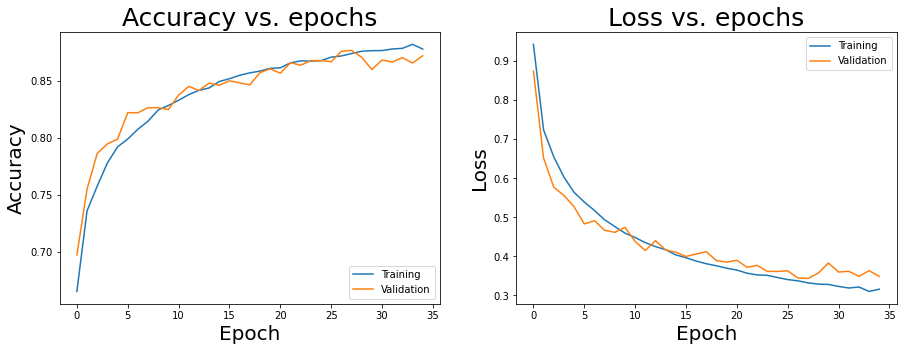

In [150]:
# plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs',fontsize = 25)
plt.ylabel('Accuracy',fontsize = 20)
plt.xlabel('Epoch',fontsize = 20)
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs',fontsize = 25)
plt.ylabel('Loss',fontsize = 20)
plt.xlabel('Epoch',fontsize = 20)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

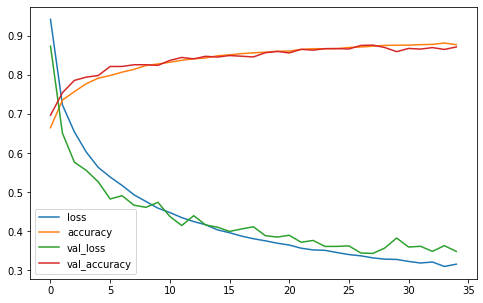

In [128]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()